In [ ]:
#!pip install openai==0.27.3

In [1]:
import pandas as pd
import numpy as np
import requests
import time
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from getpass import getpass
import matplotlib.pyplot as plt
import seaborn as sns
import openai
openai.api_key = getpass()

BASE = "https://www.u-cursos.cl/ingenieria/2/novedades_institucion/?p="
QUESTION = "¿Puedes detectar sesgo de género en el siguiente texto?"

········


# Scrap

In [ ]:
def get_page_posts(page_num):
    r = requests.get(f"{BASE}{page_num}")
    soup = BeautifulSoup(r.content, "html.parser")
    posts = soup.find_all("div", class_="post objeto")
    
    return [
        {
            "titulo": p.find("h1").get_text().split("\n")[0].strip(),
            "url": p.find("a", href=True)["href"],
            "mensaje": p.find("div", class_="msg").get_text(),
            "fecha": p.find("span", class_="only-excel").get_text()
        }
        for p in posts
    ]


posts_all = [
    get_page_posts(i)
    for i in tqdm(range(866))
]

In [ ]:
df = pd.DataFrame([
    p
    for pp in posts_all
    for p in pp
])

print(df.shape)
df.head()

In [ ]:
df["m_parsed"] = df["mensaje"].replace([r"\n", r"\r"], [" ", " "], regex=True).str.strip()
df.head()

In [ ]:
df.to_csv("../../data/raw/20230403_novedades_fcfm.csv", index=False)

In [5]:
df = pd.read_csv("../../data/raw/20230403_novedades_fcfm.csv")
df["fecha"] = pd.to_datetime(df["fecha"])
df["fecha"].describe(datetime_is_numeric=True)

count                             8644
mean     2016-04-28 02:47:08.407218944
min                2007-10-25 16:32:25
25%                2012-05-09 17:42:09
50%                2016-10-20 15:41:50
75%      2020-01-28 23:35:58.249999872
max                2023-04-03 16:14:03
Name: fecha, dtype: object

<AxesSubplot:>

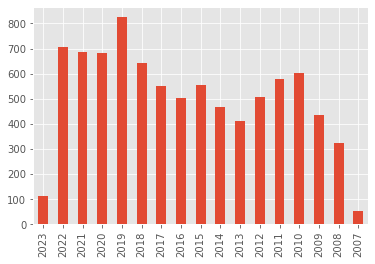

In [9]:
plt.style.use("ggplot")
df["año"] = df["fecha"].dt.year.astype(str)
df["año"].value_counts().sort_index(ascending=False).plot(kind="bar");

In [16]:
df["año"].value_counts().sort_index(ascending=False)#[1:-1].mean()

2023    112
2022    707
2021    686
2020    683
2019    825
2018    641
2017    551
2016    505
2015    554
2014    469
2013    410
2012    509
2011    579
2010    601
2009    434
2008    325
2007     53
Name: año, dtype: int64

# ChatGPT

In [300]:
def get_chatgpt_answer(question):
    answer = np.nan
    
    if isinstance(question, str) and len(question) > 0:
        time.sleep(5)
        try:
            answer = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "user", "content": question}
                ],
                request_timeout=30
            ).choices[0]["message"]["content"]
        
        except Exception as e:
            print(question[:200], e)
    
    return answer

In [ ]:
df_sample = df.sample(10, random_state=42)

df_sample["chat_gpt_answer"] = [
    get_chatgpt_answer(
        f'{QUESTION}: "{m}"'
    )
    for m in tqdm(df_sample["m_parsed"], total=df_sample.shape[0])
]

In [ ]:
df_sample.to_csv("../../data/raw/20230403_respuestas_gpt.csv")

In [ ]:
df_s2 = df[~df.index.isin(df_sample.index)].sample(1000, random_state=42)
df.shape, df_s2.shape

In [ ]:
df_s2["chat_gpt_answer"] = [
    get_chatgpt_answer(
        f'{QUESTION}: "{m}"'
    )
    for m in tqdm(df_s2["m_parsed"], total=df_s2.shape[0])
]

In [86]:
df_s2.head()

,titulo,url,mensaje,fecha,m_parsed,chat_gpt_answer
4443,U. Chile habilita compra de certificados de tí...,detalle?id=12661,Más información AQUÍ\n\n,2016-08-08 11:21:08,Más información AQUÍ,"No, no se puede detectar sesgo de género en el..."
2925,Semana Mechona Cancelada,detalle?id=25036,"Estimada comunidad,\n\r\nLes comunicamos que l...",2019-03-15 17:36:15,"Estimada comunidad, Les comunicamos que la ...",No hay sesgo de género en este texto.
4075,Postulaciones Beihang Summer School 2017,detalle?id=15503,"Estimad@s estudiantes,\n\r\nInformamos que par...",2017-04-05 16:01:05,"Estimad@s estudiantes, Informamos que para q...",No se puede detectar sesgo de género en el texto.
3693,Semestre de Verano 2017/3,detalle?id=18667,Fechas importantes\n\nInscripción académica \t...,2017-11-24 12:30:24,Fechas importantes Inscripción académica \t\t...,No hay sesgo de género en el texto.
3886,REBAJA DE ARANCEL 50%,detalle?id=17099,Se informa a los estudiantes que deban cursar ...,2017-08-07 10:02:07,Se informa a los estudiantes que deban cursar ...,No se detecta sesgo de género en el texto.


In [115]:
df_s2.to_csv("../../data/raw/20230403_respuestas_gpt_2.csv")

In [150]:
df_s3 = df_s2[df_s2["chat_gpt_answer"].isna()]
df.shape, df_s2.shape, df_s3.shape

((8644, 5), (1000, 9), (676, 9))

In [ ]:
df_s3["chat_gpt_answer"] = [
    get_chatgpt_answer(
        f'{QUESTION}: "{m}"'
    )
    for m in tqdm(df_s3["m_parsed"], total=df_s3.shape[0])
]

In [152]:
df_s3.head()

,titulo,url,mensaje,fecha,m_parsed,chat_gpt_answer,class,año_mes,año
212,Postulación beneficios estudiantiles Mineduc 2...,detalle?id=60281,Estimad@s Estudiantes: Se extiende hasta el 02...,2022-10-27 08:56:27,Estimad@s Estudiantes: Se extiende hasta el 02...,No hay sesgo de género en el texto.,NaN,2022_10,2022
3105,Open House Magcea,detalle?id=23567,,2018-11-19 16:34:19,,"Lo siento, no puedo detectar el sesgo de géner...",NaN,2018_11,2018
33,Resultados Modifica 5º - Otoño 2023,detalle?id=64333,"Estimada Comunidad,Se encuentran disponibles l...",2023-03-20 15:47:20,"Estimada Comunidad,Se encuentran disponibles l...",No se detecta sesgo de género en el texto dado.,NaN,2023_3,2023
4114,REBAJA DE ARANCEL 50% SEMESTRE OTOÑO 2017,detalle?id=15151,Se informa a los estudiantes que desde el 27 d...,2017-03-21 15:54:21,Se informa a los estudiantes que desde el 27 d...,En este texto no se detecta un sesgo de género...,NaN,2017_3,2017
702,Suspensión cobro de arancel Semestre Otoño 202...,detalle?id=51445,Se recuerda que todos los estudiantes en proce...,2022-03-10 12:43:10,Se recuerda que todos los estudiantes en proce...,No se detecta sesgo de género en el texto.,NaN,2022_3,2022


In [156]:
df_s3.to_csv("../../data/raw/20230403_respuestas_gpt_3.csv")

In [157]:
df_s4 = df_s3[df_s3["chat_gpt_answer"].isna()]
df.shape, df_s2.shape, df_s3.shape, df_s4.shape

((8644, 5), (1000, 9), (676, 9), (508, 9))

In [158]:
df_s4["chat_gpt_answer"] = [
    get_chatgpt_answer(
        f'{QUESTION}: "{m}"'
    )
    for m in tqdm(df_s4["m_parsed"], total=df_s4.shape[0])
]

  0%|          | 0/508 [00:00<?, ?it/s]

¿Puedes detectar sesgo de género en el siguiente texto?: "SEMINARIO:  "Unraveling the interior structure of planets and exoplanets using ab initio equations of states", por Stephane Mazevet (Observato Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=30)


/tmp/ipykernel_6962/4290567017.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s4["chat_gpt_answer"] = [


In [159]:
df_s4.head()

,titulo,url,mensaje,fecha,m_parsed,chat_gpt_answer,class,año_mes,año
6108,Renovación Crédito con Aval del Estado,detalle?id=5617,Estimados (as):\r\nSe adjunta nómina de estudi...,2013-03-12 10:21:12,Estimados (as): Se adjunta nómina de estudian...,No se detecta sesgo de género en el texto prop...,NaN,2013_3,2013
8426,"Controles de Primer Año, Semestre Primavera 2008",detalle?id=347,1_controles_primer_ano_08_2_(2.pdf,2008-08-07 16:52:07,1_controles_primer_ano_08_2_(2.pdf,"No, no se puede detectar sesgo de género en es...",NaN,2008_8,2008
7196,"Obra de Teatro : ""Como si fuera esta noche""",detalle?id=2804,,2011-03-09 13:00:09,,"Lo siento, sin un texto específico no es posib...",NaN,2011_3,2011
2136,Matrícula 2020 estudiantes antiguos,detalle?id=30666,El proceso de matrícula 2020 para estudiantes ...,2020-03-09 11:13:09,El proceso de matrícula 2020 para estudiantes ...,Es posible detectar sesgo de género en el sigu...,NaN,2020_3,2020
7525,PLEBISCITO GENERAL: lunes 16 y martes 17,detalle?id=2006,Invitamos a todos los estudiantes a votar la a...,2010-08-16 12:39:16,Invitamos a todos los estudiantes a votar la a...,No hay sesgo de género en el texto.,NaN,2010_8,2010


In [160]:
df_s4.to_csv("../../data/raw/20230403_respuestas_gpt_4.csv")

In [299]:
df_s5 = df[~df.index.isin(df_concat["index"])].sample(1000, random_state=42)
df.shape, df_s5.shape

((8644, 5), (1000, 5))

In [301]:
df_s5["chat_gpt_answer"] = [
    get_chatgpt_answer(
        f'{QUESTION}: "{m}"'
    )
    for m in tqdm(df_s5["m_parsed"], total=df_s5.shape[0])
]

  0%|          | 0/1000 [00:00<?, ?it/s]

¿Puedes detectar sesgo de género en el siguiente texto?: "" Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=30)


In [302]:
df_s5.to_csv("../../data/raw/20230404_respuestas_gpt_5.csv")

In [303]:
df_s5.head()

,titulo,url,mensaje,fecha,m_parsed,chat_gpt_answer
781,Consideraciones importantes proceso de matrícu...,detalle?id=50173,Matrícula Alumnos Antiguos 2022 Pregrado La Di...,2022-01-10 09:55:10,Matrícula Alumnos Antiguos 2022 Pregrado La Di...,No se detecta sesgo de género en el texto.
7240,Concurso Otoño 2011 Profesor Auxiliar Dpto. Fi...,detalle?id=2645,DEPARTAMENTO DE FISICA\r\nCONCURSO OTOÑO 2011 ...,2010-12-15 15:30:15,DEPARTAMENTO DE FISICA CONCURSO OTOÑO 2011 PR...,"Como modelo de lenguaje IA, no tengo la capaci..."
6608,Exámenes Postergados de Primavera 2011 Matemát...,detalle?id=4296,"""Los exámenes postergados de Primavera 2011 se...",2012-03-08 16:16:08,"""Los exámenes postergados de Primavera 2011 se...",No se detecta sesgo de género en el texto.
2822,Gracias,detalle?id=25692,Estimada comunidad:\r\nQuiero agradecer muy si...,2019-04-16 12:08:16,Estimada comunidad: Quiero agradecer muy sinc...,"No hay sesgo de género en el texto, ya que se ..."
4869,"CHARLA INGENIERÍA MECÁNICA, ALUMNOS DE PLAN COMÚN",detalle?id=9653,Estimados Alumnos de Plan Común: \n\r\nPresent...,2015-10-01 13:28:01,Estimados Alumnos de Plan Común: Presente y...,"Sí, se puede detectar sesgo de género en este ..."


## Concats

In [343]:
SESGO_REGEX = "no se detecta un sesgo|no se detecta sesgo|no hay sesgo|no se puede detectar sesgo|no presenta un sesgo|no presenta sesgo|no contiene sesgo de género|no detecto sesgo"
SESGO_REGEX += "|no hay sesgo de género|no puedo detectar sesgo de género|no presenta ningún sesgo de género"

# REvisión manual
SESGO_REGEX += "|no se detecta ningún sesgo|no se identifica ningún sesgo|no hay un sesgo de género|no muestra sesgo|no se percibe sesgo de género|no se observa sesgo de género"
SESGO_REGEX += "|no parece tener sesgo de género|no hay un sesgo de género|no hay evidencia de sesgo de género|no se ha detectado sesgo de género|no presenta evidencia clara de sesgo"
SESGO_REGEX += "|no contiene rasgos que sugieran preferencia o discriminación por género|no hay indicios de sesgo de género|no se aprecia sesgo|no tiene sesgo|no parece contener sesgo"
SESGO_REGEX += "|no hay evidencia clara de sesgo de género|no hay ningún sesgo de género|no detecto ningún sesgo|no existe sesgo de género|el sesgo de género no es detectable"

NAN_REGEX = "lo siento|no es posible determinar si hay sesgo de género|no tengo la capacidad de revisar documentos adjuntos|no tengo la capacidad de detectar sesgos de género en palabras aisladas"
NAN_REGEX += "|no es posible detectar sesgo de género en un nombre de archivo|no tengo habilidades para detectar sesgo de género de manera efectiva|no tengo acceso al archivo"
NAN_REGEX += "|no tengo la capacidad de detectar sesgo de género en un archivo|no tengo la capacidad de detectar sesgo de género en este contexto"
NAN_REGEX += "|no hay suficiente información para determinar si hay sesgo de género|no puedo evaluar la intención detrás del lenguaje utilizado en el texto proporcionado"
NAN_REGEX += "|no tengo la capacidad de detectar sesgo de género en documentos sin contexto|no se puede determinar si hay sesgo de género en el nombre del archivo"
NAN_REGEX += "|no estoy segura de qué texto te refieres|no se puede determinar sesgo de género en un nombre de archivo"
NAN_REGEX += "|no se puede determinar un sesgo de género en el texto|no es posible detectar sesgo de género en este nombre de archivo|no hay suficiente contexto para determinar si hay sesgo"

In [344]:
df_sample = pd.read_csv("../../data/raw/0230403_respuestas_gpt.csv").rename(columns={"Unnamed: 0": "index"})
df_sample.head()

,index,titulo,url,mensaje,fecha,m_parsed,chat_gpt_answer
0,5599,Calendario de Examenes Otoño 2014,detalle?id=7252,"Estimados alumnos, \r\nya se encuentran public...",2014-05-13 10:48:13,"Estimados alumnos, ya se encuentran publicad...",No se detecta sesgo de género en el texto.
1,6695,Seminario Haciendo Educación (Charla 7,detalle?id=4082,NaN,2011-11-22 10:34:22,NaN,"Lo siento, no puedo responder esta pregunta si..."
2,222,Concierto aniversario Coro FCFM | miércoles 26...,detalle?id=60137,Beauchefian@s: \r\n\r\nEn el marco del anivers...,2022-10-24 11:41:24,Beauchefian@s: En el marco del aniversario...,"Sí, se puede detectar un posible sesgo de géne..."
3,4829,"Entrega Cheque PAE, Séptima Cuota",detalle?id=9861,Se informa a los estudiantes que la entrega de...,2015-10-20 12:19:20,Se informa a los estudiantes que la entrega de...,No se detecta ningún sesgo de género en el texto.
4,318,Conversatorio Desafíos políticos y sociales d...,detalle?id=58285,"\r\n\r\nEstimados/as estudiantes,\r\n \r\nLes ...",2022-08-29 16:58:29,"Estimados/as estudiantes, Les invitamos a ...","En el texto se utiliza la expresión ""Estimados..."


In [345]:
df_sample["class"] = np.where(
    (df_sample["chat_gpt_answer"].notna())
    & (df_sample["chat_gpt_answer"].fillna("").str.lower().str.contains(SESGO_REGEX)),
    0,
    np.where(
        (df_sample["m_parsed"].str.len() == 0) | (df_sample["chat_gpt_answer"].isna()),
        np.nan,
        1
    )
)

df_sample["class"].value_counts(dropna=False)

0.0    6
1.0    4
Name: class, dtype: int64

,index,titulo,url,mensaje,fecha,m_parsed,chat_gpt_answer
0,5599,Calendario de Examenes Otoño 2014,detalle?id=7252,"Estimados alumnos, \r\nya se encuentran public...",2014-05-13 10:48:13,"Estimados alumnos, ya se encuentran publicad...",No se detecta sesgo de género en el texto.
1,6695,Seminario Haciendo Educación (Charla 7,detalle?id=4082,NaN,2011-11-22 10:34:22,NaN,"Lo siento, no puedo responder esta pregunta si..."
2,222,Concierto aniversario Coro FCFM | miércoles 26...,detalle?id=60137,Beauchefian@s: \r\n\r\nEn el marco del anivers...,2022-10-24 11:41:24,Beauchefian@s: En el marco del aniversario...,"Sí, se puede detectar un posible sesgo de géne..."
3,4829,"Entrega Cheque PAE, Séptima Cuota",detalle?id=9861,Se informa a los estudiantes que la entrega de...,2015-10-20 12:19:20,Se informa a los estudiantes que la entrega de...,No se detecta ningún sesgo de género en el texto.
4,318,Conversatorio Desafíos políticos y sociales d...,detalle?id=58285,"\r\n\r\nEstimados/as estudiantes,\r\n \r\nLes ...",2022-08-29 16:58:29,"Estimados/as estudiantes, Les invitamos a ...","En el texto se utiliza la expresión ""Estimados..."


In [346]:
df_s2["class"] = np.where(
    (df_s2["chat_gpt_answer"].notna())
    & (df_s2["chat_gpt_answer"].fillna("").str.lower().str.contains(SESGO_REGEX)),
    0,
    np.where(
        (df_s2["m_parsed"].str.len() == 0) | (df_s2["chat_gpt_answer"].isna()),
        np.nan,
        1
    )
)

df_s2["class"].value_counts(dropna=False)

NaN    696
0.0    232
1.0     72
Name: class, dtype: int64

In [347]:
df_s3["class"] = np.where(
    (df_s3["chat_gpt_answer"].notna())
    & (df_s3["chat_gpt_answer"].fillna("").str.lower().str.contains(SESGO_REGEX)),
    0,
    np.where(
        (df_s3["m_parsed"].str.len() == 0) | (df_s3["chat_gpt_answer"].isna()),
        np.nan,
        1
    )
)

df_s3["class"].value_counts(dropna=False)

/tmp/ipykernel_6962/2865054334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s3["class"] = np.where(


NaN    520
0.0    124
1.0     32
Name: class, dtype: int64

In [348]:
df_s4["class"] = np.where(
    (df_s4["chat_gpt_answer"].notna())
    & (df_s4["chat_gpt_answer"].fillna("").str.lower().str.contains(SESGO_REGEX)),
    0,
    np.where(
        (df_s4["m_parsed"].str.len() == 0) | (df_s4["chat_gpt_answer"].isna()),
        np.nan,
        1
    )
)

df_s4["class"].value_counts(dropna=False)

/tmp/ipykernel_6962/2180059309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s4["class"] = np.where(


0.0    374
1.0    116
NaN     18
Name: class, dtype: int64

In [349]:
df_s5["class"] = np.where(
    (df_s5["chat_gpt_answer"].notna())
    & (df_s5["chat_gpt_answer"].fillna("").str.lower().str.contains(SESGO_REGEX)),
    0,
    np.where(
        (df_s5["m_parsed"].str.len() == 0) | (df_s5["chat_gpt_answer"].isna()),
        np.nan,
        1
    )
)

df_s5["class"].value_counts(dropna=False)

0.0    700
1.0    253
NaN     47
Name: class, dtype: int64

In [350]:
df_concat = pd.concat([
    df_sample,
    df_s2.dropna(subset=["chat_gpt_answer"]).reset_index(),
    df_s3.dropna(subset=["chat_gpt_answer"]).reset_index(),
    df_s4.dropna(subset=["chat_gpt_answer"]).reset_index(),
    df_s5.dropna(subset=["chat_gpt_answer"]).reset_index()
]).reset_index(drop=True)

print(df.shape, df_concat.shape)
df_concat.head()

(8644, 5) (2008, 10)


,index,titulo,url,mensaje,fecha,m_parsed,chat_gpt_answer,class,año_mes,año
0,5599,Calendario de Examenes Otoño 2014,detalle?id=7252,"Estimados alumnos, \r\nya se encuentran public...",2014-05-13 10:48:13,"Estimados alumnos, ya se encuentran publicad...",No se detecta sesgo de género en el texto.,0.0,NaN,NaN
1,6695,Seminario Haciendo Educación (Charla 7,detalle?id=4082,NaN,2011-11-22 10:34:22,NaN,"Lo siento, no puedo responder esta pregunta si...",1.0,NaN,NaN
2,222,Concierto aniversario Coro FCFM | miércoles 26...,detalle?id=60137,Beauchefian@s: \r\n\r\nEn el marco del anivers...,2022-10-24 11:41:24,Beauchefian@s: En el marco del aniversario...,"Sí, se puede detectar un posible sesgo de géne...",1.0,NaN,NaN
3,4829,"Entrega Cheque PAE, Séptima Cuota",detalle?id=9861,Se informa a los estudiantes que la entrega de...,2015-10-20 12:19:20,Se informa a los estudiantes que la entrega de...,No se detecta ningún sesgo de género en el texto.,1.0,NaN,NaN
4,318,Conversatorio Desafíos políticos y sociales d...,detalle?id=58285,"\r\n\r\nEstimados/as estudiantes,\r\n \r\nLes ...",2022-08-29 16:58:29,"Estimados/as estudiantes, Les invitamos a ...","En el texto se utiliza la expresión ""Estimados...",1.0,NaN,NaN


In [351]:
df_concat.isna().sum()

index                 0
titulo                0
url                   0
mensaje               1
fecha                 0
m_parsed              1
chat_gpt_answer       0
class                95
año_mes            1009
año                1009
dtype: int64

In [352]:
assert df_concat["index"].value_counts().max() == 1
df_concat[df_concat["class"].isna()]["mensaje"].value_counts()

      94
\n     1
Name: mensaje, dtype: int64

In [353]:
vc = df_concat["mensaje"].value_counts()
repetidos = vc[vc > 1].index
df_concat[df_concat["mensaje"].isin(repetidos)].sort_values(by=["mensaje"], ascending=False).head(10)

,index,titulo,url,mensaje,fecha,m_parsed,chat_gpt_answer,class,año_mes,año
184,5498,Boletín de noticias Beauchef al día,detalle?id=7561,Ya apareció una nueva edición del Boletín de N...,2014-07-23 12:40:23,Ya apareció una nueva edición del Boletín de N...,"No, no se detecta sesgo de género en el texto.",0.0,2014_7,2014
784,5471,Boletín de noticias Beauchef al día,detalle?id=7648,Ya apareció una nueva edición del Boletín de N...,2014-08-06 12:52:06,Ya apareció una nueva edición del Boletín de N...,"No, este texto no presenta sesgo de género.",0.0,2014_8,2014
408,5487,Boletín de noticias Beauchef al día,detalle?id=7608,Ya apareció una nueva edición del Boletín de N...,2014-07-30 13:06:30,Ya apareció una nueva edición del Boletín de N...,No detecto sesgo de género en el texto.,0.0,2014_7,2014
405,5464,Boletín de noticias Beauchef al día,detalle?id=7680,Ya apareció una nueva edición del Boletín de N...,2014-08-13 15:48:13,Ya apareció una nueva edición del Boletín de N...,No hay sesgo de género en el texto.,0.0,2014_8,2014
420,6149,Renovación CAE 2013,detalle?id=5414,Si estás cursando tú carrera con apoyo del Cré...,2012-12-11 18:46:11,Si estás cursando tú carrera con apoyo del Cré...,No se detecta sesgo de género en el texto.,0.0,2012_12,2012
1215,6142,Renovación CAE 2013,detalle?id=5489,Si estás cursando tú carrera con apoyo del Cré...,2013-01-08 09:44:08,Si estás cursando tú carrera con apoyo del Cré...,No se detecta sesgo de género en el texto.,0.0,NaN,NaN
1114,1210,"Último plazo, Pagaré de Arancel, Matrícula 202...",detalle?id=43538,Servicios Centrales ha dispuesto por última ve...,2021-07-08 19:55:08,Servicios Centrales ha dispuesto por última ve...,No se detecta sesgo de género en el texto.,0.0,NaN,NaN
1779,1190,"Último plazo, Pagaré de Arancel, Matrícula 202...",detalle?id=43954,Servicios Centrales ha dispuesto por última ve...,2021-07-26 11:40:26,Servicios Centrales ha dispuesto por última ve...,No se detecta sesgo de género en el texto.,0.0,NaN,NaN
75,2883,Postergación Otoño 2019,detalle?id=25302,Se recuerda a los estudiantes matriculados que...,2019-03-27 12:36:27,Se recuerda a los estudiantes matriculados que...,No se detecta sesgo de género en este texto.,0.0,2019_3,2019
807,2910,Postergación Otoño 2019,detalle?id=25116,Se recuerda a los estudiantes matriculados que...,2019-03-19 17:49:19,Se recuerda a los estudiantes matriculados que...,No hay sesgo de género en el texto.,0.0,2019_3,2019


In [354]:
t = pd.DataFrame(
    df_concat[df_concat["mensaje"].isin(repetidos)].groupby(["mensaje"])["class"].value_counts()
).rename(columns={
    "class": "cuentas"
}).reset_index()

# En mensajes repetidos se obtuvo la misma clase
assert t.shape[0] == t["mensaje"].nunique()

# Análisis

In [355]:
df_concat["fecha"] = pd.to_datetime(df_concat["fecha"])
df_concat["fecha"].describe(datetime_is_numeric=True)

count                             2008
mean     2016-07-05 07:58:04.977589760
min                2007-10-29 16:41:29
25%                2012-08-12 15:05:42
50%         2017-01-17 06:41:46.500000
75%      2020-05-16 20:52:46.249999872
max                2023-03-29 11:05:29
Name: fecha, dtype: object

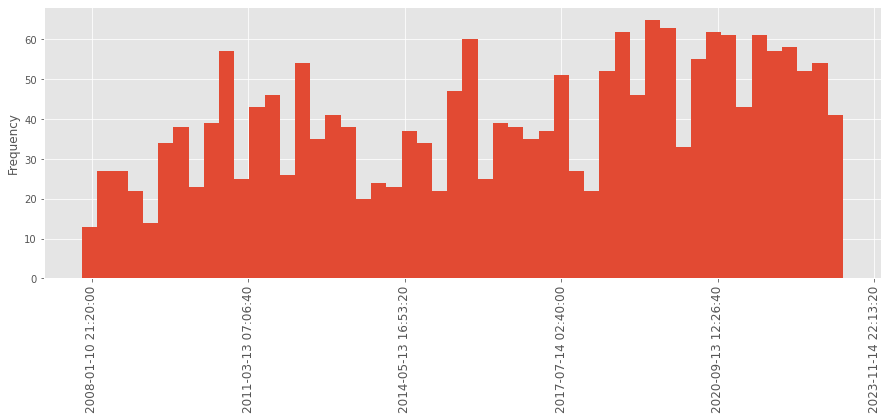

In [356]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(15, 5))
df_concat["fecha"].astype(np.int64).plot.hist(ax=ax, bins=50)
labels = ax.get_xticks().tolist()[1:-1]
ax.set_xticks(labels)
ax.set_xticklabels(pd.to_datetime(labels), rotation=90, size=12)
plt.show()

In [357]:
#df_s2["año_mes"] = df_s2["fecha"].dt.year.astype(str) + "_" + df_s2["fecha"].dt.month.astype(str) 
df_concat["año"] = df_concat["fecha"].dt.year.astype(str)
df_concat["año"].value_counts().sort_index(ascending=False)

2023     36
2022    169
2021    174
2020    171
2019    190
2018    147
2017    118
2016    117
2015    139
2014    101
2013     85
2012    137
2011    113
2010    136
2009     86
2008     77
2007     12
Name: año, dtype: int64

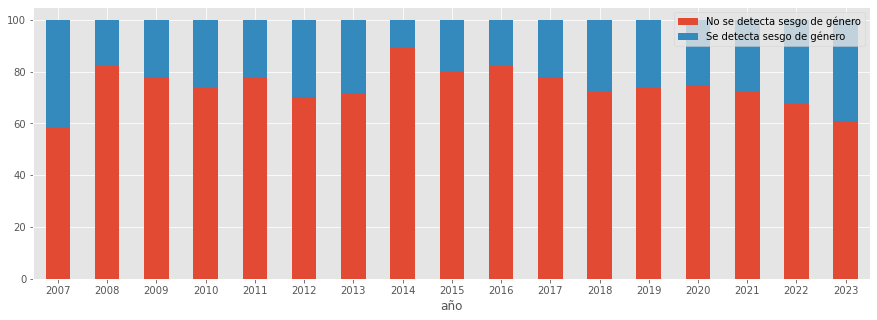

In [359]:
# plt.figure(figsize=(15, 5))
# sns.countplot(x="año", hue="class", data=df_concat, order=sorted(df_concat["año"].unique()));
# plt.legend(labels=['No se detecta sesgo de género', 'Se detecta sesgo de género']);

t2 = pd.DataFrame(
    df_concat.groupby(["año"])["class"].value_counts("%") * 100
    #df_concat.groupby(["año"])["class"].value_counts()
).rename(columns={
    "class": "cuenta"
}).reset_index()

pivot = pd.pivot_table(data=t2, index=['año'], columns=['class'], values='cuenta')

ax = pivot.plot.bar(stacked=True, figsize=(15,5))
ax.set_xticklabels(pivot.index, rotation=0)
plt.legend(labels=['No se detecta sesgo de género', 'Se detecta sesgo de género']);

In [361]:
df_concat.to_csv("../../data/processed/20230404_avisos_gpt_sample_2000.csv", index=False, sep="|")

In [20]:
pd.read_csv("../../data/raw/processed/20230404_avisos_gpt_sample_2000.csv", sep="|")

,index,titulo,url,mensaje,fecha,m_parsed,chat_gpt_answer,class,año_mes,año
0,5599,Calendario de Examenes Otoño 2014,detalle?id=7252,"Estimados alumnos, \r\nya se encuentran public...",2014-05-13 10:48:13,"Estimados alumnos, ya se encuentran publicad...",No se detecta sesgo de género en el texto.,0.0,NaN,2014
1,6695,Seminario Haciendo Educación (Charla 7,detalle?id=4082,NaN,2011-11-22 10:34:22,NaN,"Lo siento, no puedo responder esta pregunta si...",1.0,NaN,2011
2,222,Concierto aniversario Coro FCFM | miércoles 26...,detalle?id=60137,Beauchefian@s: \r\n\r\nEn el marco del anivers...,2022-10-24 11:41:24,Beauchefian@s: En el marco del aniversario...,"Sí, se puede detectar un posible sesgo de géne...",1.0,NaN,2022
3,4829,"Entrega Cheque PAE, Séptima Cuota",detalle?id=9861,Se informa a los estudiantes que la entrega de...,2015-10-20 12:19:20,Se informa a los estudiantes que la entrega de...,No se detecta ningún sesgo de género en el texto.,1.0,NaN,2015
4,318,Conversatorio Desafíos políticos y sociales d...,detalle?id=58285,"\r\n\r\nEstimados/as estudiantes,\r\n \r\nLes ...",2022-08-29 16:58:29,"Estimados/as estudiantes, Les invitamos a ...","En el texto se utiliza la expresión ""Estimados...",1.0,NaN,2022
...,...,...,...,...,...,...,...,...,...,...
2003,485,Hoy - FabLab sale del Lab,detalle?id=54937,Estimada comunidad beauchefiana:El Laboratorio...,2022-06-02 10:03:02,Estimada comunidad beauchefiana:El Laboratorio...,No se detecta sesgo de género en este texto.,0.0,NaN,2022
2004,1901,Mañana en la FCFM (en línea) - viernes 26 de j...,detalle?id=32900,ENCUENTRO:\r\nXXVII Encuentro Virtual de Gesti...,2020-06-25 17:41:25,ENCUENTRO: XXVII Encuentro Virtual de Gestión...,No se detecta sesgo de género en el texto prop...,0.0,NaN,2020
2005,812,Matrícula Alumnos Antiguos 2022,detalle?id=49853,El proceso de Matrícula 2022 para estudiantes ...,2022-01-04 09:47:04,El proceso de Matrícula 2022 para estudiantes ...,No se detecta un sesgo de género en el texto.,0.0,NaN,2022
2006,557,Becas Santander Skills | MBA Essentials 2022 ...,detalle?id=53869,"Estimada Comunidad,Les invitamos a informarse ...",2022-04-29 11:01:29,"Estimada Comunidad,Les invitamos a informarse ...",No se detecta sesgo de género en el texto.,0.0,NaN,2022
